<a href="https://colab.research.google.com/github/catafest/colab_google/blob/master/catafest_0059.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

define HParams

In [14]:
from dataclasses import dataclass, field

symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
           ' ', '!', '.', ',', '?', "'"]  # Define symbols outside the class

@dataclass
class HParams:
    # Experiment Parameters
    epochs: int = 500
    iters_per_checkpoint: int = 1000
    seed: int = 1234
    dynamic_loss_scaling: bool = True
    fp16_run: bool = False
    distributed_run: bool = False
    dist_backend: str = "nccl"
    dist_url: str = "tcp://localhost:54321"
    cudnn_enabled: bool = True
    cudnn_benchmark: bool = False

    ignore_layers: list = field(default_factory=list)  # Changed line    # Text Parameters
    text_cleaners: list = field(default_factory=lambda: ['english_cleaners'])  # Use default_factory
    # Mel parameters
    n_mel_channels: int = 80
    # n_mel_channels: int = 256
    # filter_length: int = 1024
    filter_length: int = 2048
    # hop_length: int = 256
    hop_length: int = 512
    # win_length: int = 1024
    win_length: int = 2048
    sampling_rate: int = 22050
    mel_fmin: float = 0.0
    mel_fmax: float = 8000.0

    # Model Parameters
    n_symbols: int = field(init=False)  # Indicate that n_symbols is calculated later
    symbols_embedding_dim: int = 512

    # Encoder parameters
    encoder_kernel_size: int = 5
    encoder_n_convolutions: int = 3
    encoder_embedding_dim: int = 512

    # Decoder parameters
    n_frames_per_step: int = 1  # currently only 1 is supported
    decoder_rnn_dim: int = 1024
    prenet_dim: int = 256
    max_decoder_steps: int = 1000
    gate_threshold: float = 0.5
    p_attention_dropout: float = 0.1
    p_decoder_dropout: float = 0.1
    # Adăugați atributul mask_padding:
    mask_padding: bool = True
    # Attention parameters
    attention_rnn_dim: int = 1024
    attention_dim: int = 128

    # Location Layer parameters
    attention_location_n_filters: int = 32
    attention_location_kernel_size: int = 31

    # Mel-post processing network parameters
    postnet_embedding_dim: int = 512
    postnet_kernel_size: int = 5
    postnet_n_convolutions: int = 5

    # Optimization parameters
    use_saved_learning_rate: bool = False
    learning_rate: float = 1e-3
    weight_decay: float = 1e-6
    grad_clip_thresh: float = 1.0
    batch_size: int = 64  # set model's padded outputs to padded values

    def __post_init__(self):
        self.n_symbols = len(symbols)  # Calculate n_symbols after initialization


def create_hparams(hparams_string=None, verbose=False):
    """Create model hyperparameters. Parse nondefault from given string."""

    hparams = HParams()
    if hparams_string:
        print('Parsing command line hparams: %s', hparams_string)
        #hparams.parse(hparams_string) #Removed this line, as it was causing errors

    if verbose:
        print('Final parsed hparams: %s', hparams.values())#hparams.values() changed to vars(hparams)

    return hparams

In [15]:
!pip install librosa==0.9.2
!pip install --upgrade tensorflow
!pip install denoiser


If you want to use next cell then you need to set runtime to T4 GPU.


In [16]:
project_name = "tacotron2"  # Înlocuiți cu calea corectă către proiect
tacotron2_pretrained_model = "tacotron2_statedict.pt"  # Înlocuiți cu calea corectă
waveglow_pretrained_model = "waveglow_old.pt"

In [17]:
%cd /content

gpu = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader
print("Current GPU: " + gpu[0])

if gpu[0] == "Tesla K80" and optix_enabled:
  print("OptiX disabled because of unsupported GPU")
  optix_enabled = False

/content
Current GPU: Tesla T4


In [18]:
# @title Memory Information

import psutil
from IPython.display import HTML, display

def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor

# Retrieve memory information
svmem = psutil.virtual_memory()
total = get_size(svmem.total)
available = get_size(svmem.available)
used = get_size(svmem.used)
percentage = svmem.percent

# Create an HTML table with memory information (Rounded Corners variant with dark theme)
table_content = f"""
<table>
    <tr>
        <th colspan="2">Memory Information</th>
    </tr>
    <tr>
        <th>Total</th>
        <td>{total}</td>
    </tr>
    <tr>
        <th>Available</th>
        <td>{available}</td>
    </tr>
    <tr>
        <th>Used</th>
        <td>{used}</td>
    </tr>
    <tr>
        <th>Percentage</th>
        <td>{percentage}%</td>
    </tr>
</table>
"""

# Display the table
display(HTML(table_content))

Let's start

In [19]:
#@title
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  !cd {project_name}/waveglow && git checkout 9168aea
  !pip install -q librosa unidecode
  !pip install -q --upgrade gdown




In [20]:
import torch
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp32')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

In [21]:
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp32')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

In [22]:

!tf_upgrade_v2 --intree "/content/tacotron2" --outtree "/content/tacotron2_v2" --reportfile "/content/report.txt"


2025-04-13 14:44:16.152097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744555456.179322   36959 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744555456.186000   36959 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744555456.202317   36959 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744555456.202360   36959 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744555456.202364   36959 computation_placer.cc:177] computation placer alr

# Tacotron2 with the pretrained model

In [23]:
# initialize Tacotron2 with the pretrained model
import torch
import sys
import os

# Add the tacotron2 directory to the Python path
# Assuming tacotron2 is cloned to /content/tacotron2
tacotron2_dir = os.path.abspath(os.path.join(os.getcwd(), 'tacotron2'))
sys.path.insert(0, tacotron2_dir)

# If 'utils' is already in sys.modules, remove it
if 'utils' in sys.modules:
    del sys.modules['utils']

# Import the correct utils module
from utils import to_gpu, get_mask_from_lengths  # Import directly from utils.py

from model import Tacotron2

hparams = create_hparams()
hparams.sampling_rate = 22050
# model = Tacotron2(hparams)  # Nu mai este necesar

# Încărcați modelul pre-antrenat Tacotron2 folosind torch.hub
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp32')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

# initialize Waveglow with the pretrained model
# waveglow = torch.load(waveglow_pretrained_model)['model']  # Nu mai este necesar
# WORKAROUND for: https://github.com/NVIDIA/tacotron2/issues/182  # Nu mai este necesar
# import json  # Nu mai este necesar
# from glow import WaveGlow  # Nu mai este necesar
# waveglow_config = json.load(open('%s/waveglow/config.json' % project_name))['waveglow_config']  # Nu mai este necesar
# waveglow = WaveGlow(**waveglow_config)  # Nu mai este necesar
# waveglow.load_state_dict(torch.load(waveglow_pretrained_model)['model'].state_dict())  # Nu mai este necesar

# Încărcați modelul pre-antrenat WaveGlow folosind torch.hub
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp32')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

# denoiser = Denoiser(waveglow)  # Utilizează modelul waveglow încărcat de torch.hub

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

In [24]:
INPUT_TEXT = "I speak about how Waveglow is really awesome!"

In [25]:
from text import text_to_sequence
import torch
import numpy as np
from IPython.display import Audio # Import Audio
# Încărcați modelul pre-antrenat WaveGlow folosind torch.hub
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp32')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

sequence = np.array(text_to_sequence(INPUT_TEXT, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).long()
sequence = sequence.cuda()

# Calculați lungimile secvențelor de intrare
input_lengths = torch.LongTensor([sequence.shape[1]]).cuda()

# Obțineți mel_outputs_postnet din modelul Tacotron2
with torch.no_grad():
    mel_outputs, mel_outputs_postnet, alignments = tacotron2.infer(sequence, input_lengths)
    print("Forma lui mel_outputs:", mel_outputs.shape)
    print("Forma lui mel_outputs_postnet:", mel_outputs_postnet.shape)
    print("Forma lui alignments:", alignments.shape)

# Verificați și corectați dimensiunea lui mel_outputs_postnet
print("Dimensiunea originală a lui mel_outputs_postnet:", mel_outputs_postnet.shape)  # Adăugat pentru debugging

# Dacă mel_outputs_postnet are o dimensiune suplimentară, eliminați-o
if len(mel_outputs_postnet.shape) == 3 and mel_outputs_postnet.shape[0] == 1:
    mel_outputs_postnet = mel_outputs_postnet.squeeze(0)

print("Dimensiunea lui mel_outputs_postnet după ajustare:", mel_outputs_postnet.shape)  # Adăugat pentru debugging

# Utilizează mel_outputs în loc de mel_outputs_postnet
audio = waveglow.infer(mel_outputs, sigma=0.666) # Schimbă mel_outputs_postnet cu mel_outputs
Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Forma lui mel_outputs: torch.Size([1, 80, 239])
Forma lui mel_outputs_postnet: torch.Size([1])
Forma lui alignments: torch.Size([1, 239, 45])
Dimensiunea originală a lui mel_outputs_postnet: torch.Size([1])
Dimensiunea lui mel_outputs_postnet după ajustare: torch.Size([1])


In [33]:
import matplotlib.pyplot as plt

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower',
                       interpolation='none')
    plt.show()

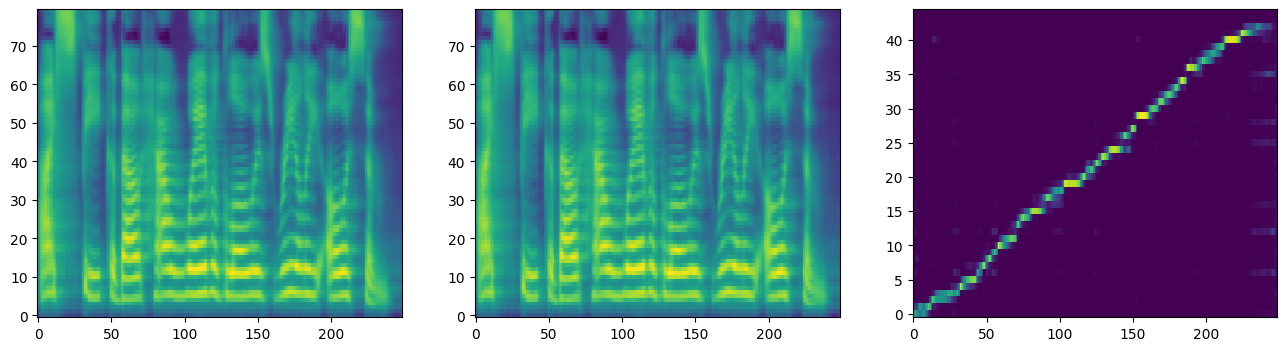

In [39]:
sequence = np.array(text_to_sequence(INPUT_TEXT, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).long()
sequence = sequence.cuda()

# Calculate input_lengths
input_lengths = torch.LongTensor([sequence.shape[1]]).cuda()

# Use tacotron2 instead of model
# Assuming tacotron2.infer is the correct method to call for inference
# Pass input_lengths to infer method
# Changed line: Removed the extra '_' variable for unpacking
mel_outputs, mel_outputs_postnet, alignments = tacotron2.infer(sequence, input_lengths)

# plot_data expects 2D arrays for visualization
# mel_outputs_postnet and alignments have the expected shapes

# Selecting the first element (index 0) from mel_outputs & mel_outputs_postnet
# to get 2D arrays suitable for plotting with imshow:
# Fixed: Indexing mel_outputs and mel_outputs_postnet correctly
#Instead of plotting mel_outputs_postnet which is 1 dimensional we plot mel_outputs[0] which is 2 dimensional
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))